In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.6.0


In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
                                        'tf_flowers',
                                        split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                        with_info=True,
                                        as_supervised=True,                                        
                                    )

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

class_names = metadata.features['label'].names
print(class_names)

5
['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


In [5]:
nb_batch = 32
nb_epochs = 200
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 180
dropout_rate = 0.3
learning_rate = 1e-4

resize_and_rescale = keras.Sequential([
                                    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
                                    layers.experimental.preprocessing.Rescaling(1./255)
                                ])

data_augmentation_layer = keras.Sequential([
                                    keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                    keras.layers.experimental.preprocessing.RandomRotation(0.05)
                                ])


def configure_for_performance(ds, shuffle=False, augment=False):
    ds = ds.cache()

    ds = ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(nb_batch)

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation_layer(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [6]:
new_train_ds = configure_for_performance(train_ds, shuffle=True, augment=True)
new_val_ds = configure_for_performance(val_ds)
new_test_ds = configure_for_performance(test_ds)

원본 이미지 확인

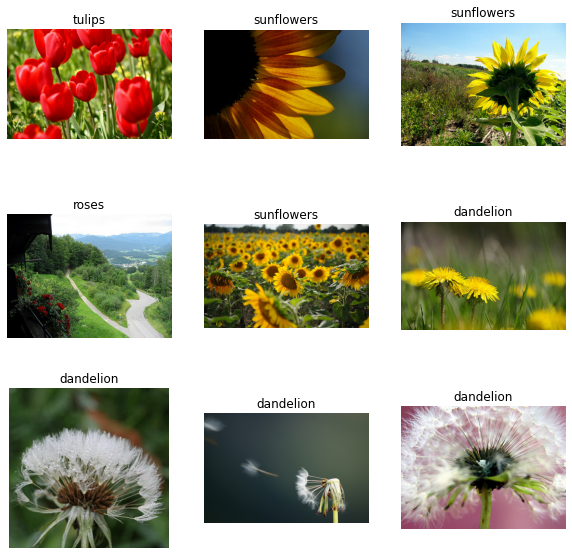

In [7]:
plt.figure(figsize=(10, 10))
iter_ds = iter(train_ds)

for i in range(9):
    image, label = next(iter_ds)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(class_names[label])
    plt.axis("off")


학습용 이미지 확인

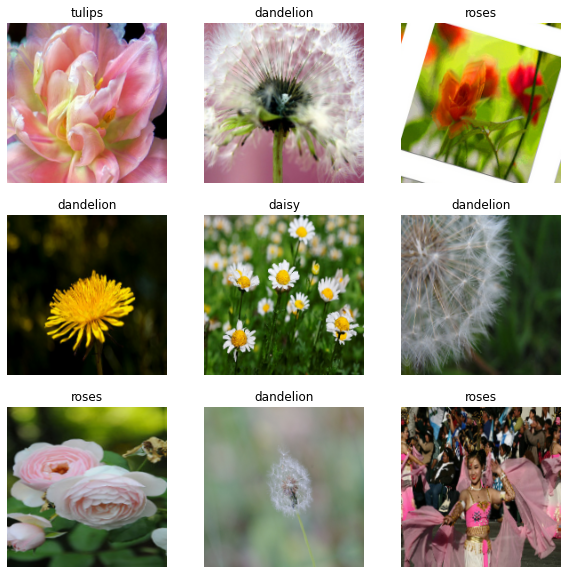

In [8]:
plt.figure(figsize=(10, 10))
iter_ds = iter(new_train_ds)
images, labels = next(iter_ds)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(class_names[labels[i]])
    plt.axis("off")

모델 생성

In [9]:
base_model = keras.applications.ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            weights='imagenet',
                                            include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

모델 요약

In [10]:
print("Number of layers in the base model: ", len(base_model.layers))
model.summary()

Number of layers in the base model:  190
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 6, 6, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 25,668,101
Trainable params: 2,103,301
Non-trainable params: 23,564,800


In [11]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate),
              metrics=['accuracy'])

콜백함수 설정

In [12]:
callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True,
                                         monitor='val_loss')

lr_reducer = keras.callbacks.ReduceLROnPlateau(factor=0.1,
                                               cooldown=0,
                                               patience=5,
                                               min_lr=0.1e-6)

모델 학습

In [13]:
hist = model.fit(new_train_ds, batch_size=nb_batch, epochs=nb_epochs,
                 verbose=1, validation_data=new_val_ds,
                 shuffle=True,
                 callbacks=[callback, lr_reducer])

Epoch 1/200
92/92 [==============================] - 11s 70ms/step - loss: 0.8134 - accuracy: 0.6901 - val_loss: 0.4475 - val_accuracy: 0.8474
Epoch 2/200
92/92 [==============================] - 5s 51ms/step - loss: 0.4449 - accuracy: 0.8454 - val_loss: 0.3778 - val_accuracy: 0.8747
Epoch 3/200
92/92 [==============================] - 5s 51ms/step - loss: 0.3684 - accuracy: 0.8716 - val_loss: 0.3538 - val_accuracy: 0.8692
Epoch 4/200
92/92 [==============================] - 5s 51ms/step - loss: 0.2992 - accuracy: 0.8948 - val_loss: 0.3332 - val_accuracy: 0.8856
Epoch 5/200
92/92 [==============================] - 5s 51ms/step - loss: 0.2631 - accuracy: 0.9053 - val_loss: 0.3327 - val_accuracy: 0.8638
Epoch 6/200
92/92 [==============================] - 5s 51ms/step - loss: 0.2292 - accuracy: 0.9220 - val_loss: 0.3071 - val_accuracy: 0.8965
Epoch 7/200
92/92 [==============================] - 5s 52ms/step - loss: 0.2050 - accuracy: 0.9305 - val_loss: 0.3059 - val_accuracy: 0.8883
Epoch

학습 이력 확인

12/12 - 1s - loss: 0.3307 - accuracy: 0.8965

Test accuracy: 89.65%


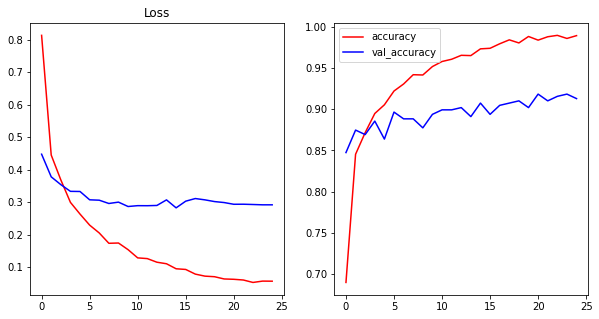

In [14]:
test_loss, test_acc = model.evaluate(new_test_ds, verbose=2)
print('\nTest accuracy: {:.2f}%'.format(test_acc * 100))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], 'r-', label='loss')
plt.plot(hist.history['val_loss'], 'b-', label='val_loss')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], 'r-', label='accuracy')
plt.plot(hist.history['val_accuracy'], 'b-', label='val_accuracy')
plt.legend()
plt.show()

전이학습 미세 조정

In [20]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate / 20.0),
              metrics=['accuracy'])

model.summary()

print('Trainable params:', len(model.trainable_variables))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 6, 6, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 25,668,101
Trainable params: 22,663,173
Non-trainable params: 3,004,928
_________________________________________

In [21]:
pre_train_epochs = hist.epoch[-1]
fine_tune_epochs = 50
total_epochs = pre_train_epochs + fine_tune_epochs

hist_fine = model.fit(new_train_ds, batch_size=nb_batch, epochs=total_epochs,
                 initial_epoch=hist.epoch[-1],
                 verbose=1, validation_data=new_val_ds,
                 shuffle=True,
                 callbacks=[callback, lr_reducer])

Epoch 25/74
92/92 [==============================] - 12s 98ms/step - loss: 0.0414 - accuracy: 0.9877 - val_loss: 0.3082 - val_accuracy: 0.9101
Epoch 26/74
92/92 [==============================] - 9s 93ms/step - loss: 0.0269 - accuracy: 0.9928 - val_loss: 0.3169 - val_accuracy: 0.9128
Epoch 27/74
92/92 [==============================] - 9s 93ms/step - loss: 0.0225 - accuracy: 0.9956 - val_loss: 0.3092 - val_accuracy: 0.9128
Epoch 28/74
92/92 [==============================] - 9s 91ms/step - loss: 0.0176 - accuracy: 0.9949 - val_loss: 0.3299 - val_accuracy: 0.9128
Epoch 29/74
92/92 [==============================] - 9s 91ms/step - loss: 0.0177 - accuracy: 0.9939 - val_loss: 0.3258 - val_accuracy: 0.9101
Epoch 30/74
92/92 [==============================] - 9s 92ms/step - loss: 0.0150 - accuracy: 0.9963 - val_loss: 0.3242 - val_accuracy: 0.9183
Epoch 31/74
92/92 [==============================] - 9s 95ms/step - loss: 0.0129 - accuracy: 0.9952 - val_loss: 0.3169 - val_accuracy: 0.9183
Epoch

12/12 - 1s - loss: 0.3860 - accuracy: 0.9046
Test accuracy: 89.65%
Fine tune test accuracy: 90.46%


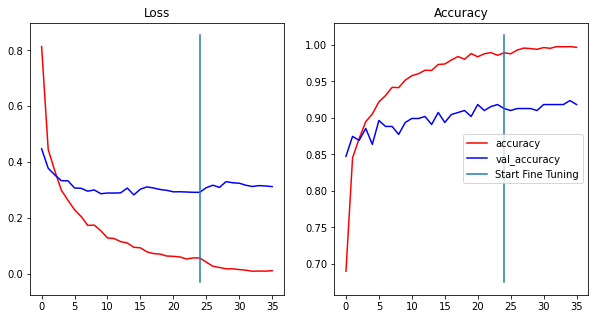

In [22]:
fine_test_loss, fine_test_acc = model.evaluate(new_test_ds, verbose=2)
print('Test accuracy: {:.2f}%'.format(test_acc * 100))
print('Fine tune test accuracy: {:.2f}%'.format(fine_test_acc * 100))

acc = hist.history['accuracy'] + hist_fine.history['accuracy']
val_acc = hist.history['val_accuracy'] + hist_fine.history['val_accuracy']

loss = hist.history['loss'] + hist_fine.history['loss']
val_loss = hist.history['val_loss'] + hist_fine.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(loss, 'r-', label='loss')
plt.plot(val_loss, 'b-', label='val_loss')
plt.plot([pre_train_epochs, pre_train_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(acc, 'r-', label='accuracy')
plt.plot(val_acc, 'b-', label='val_accuracy')
plt.plot([pre_train_epochs, pre_train_epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend()
plt.title('Accuracy')
plt.show()


학습 결과 확인

In [18]:
# 학습 결과 테스트를 이미지화 함수
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)


def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(len(predictions_array)))
    plt.yticks([])
    thisplot = plt.bar(range(len(predictions_array)),
                       predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

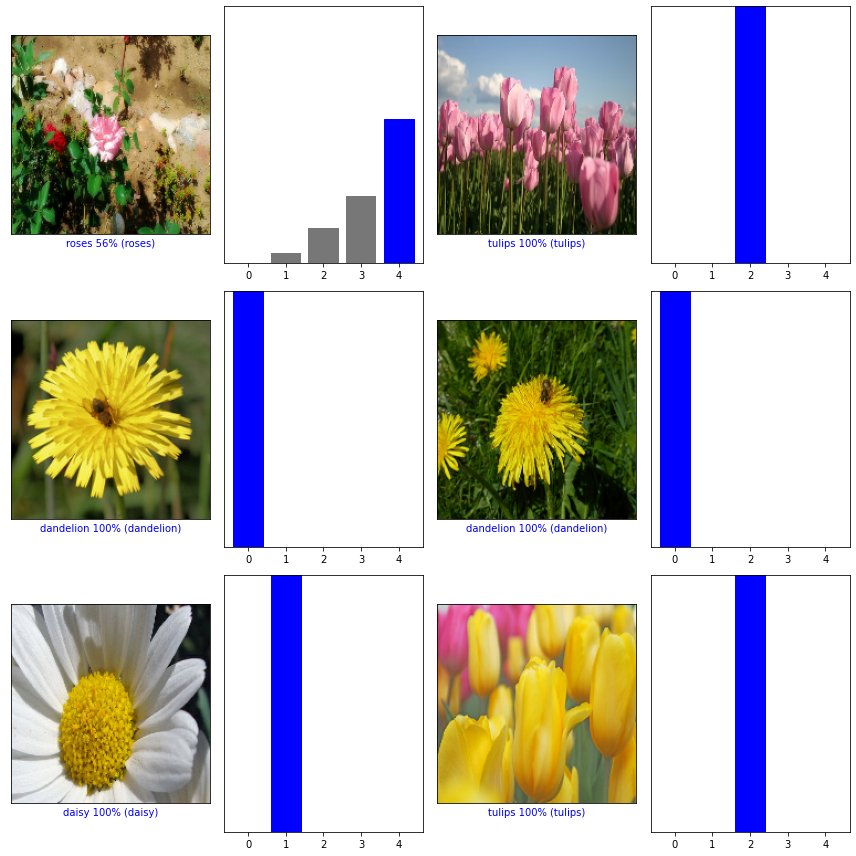

In [23]:
# 예측 결과 이미지화
test_iter = iter(new_test_ds.shuffle(nb_batch))
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(3*2*num_cols, 4*num_rows))

test_img_list, test_label_list = next(test_iter)

# Test 이미지 예측
predictions = model.predict(test_img_list)

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_label_list, test_img_list)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_label_list)
plt.tight_layout()
plt.show()
